In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.modeling.models import BlackBody
from astropy.io import fits

from scipy.optimize import curve_fit, Bounds

from pypika import Table, CustomFunction
from pypika.dialects import MSSQLQuery

from astroquery.gaia import Gaia

import sympy as sp

pd.set_option('display.max_columns', None)

## Retrieve data on Sirius A from Hipparcos catalog

In [2]:
# Get Coordinates for query by name
c_a = SkyCoord.from_name("Sirius A")

def queryStarsFromHipparcos(coor, radius, top=100):
    src = Table("public.hipparcos")
    funcDistance = CustomFunction('DISTANCE', ['ra_value', 'dec_value', 'ra_label', 'dec_label'])

    q = MSSQLQuery \
        .from_(src) \
        .select(src.b_v, src.dedms, src.hip, src.plx, src.rahms, src.sptype, src.vmag) \
        .top(top) \
        .where(funcDistance(coor.ra.value, coor.dec.value, 'ra', 'de') < radius) 

    query_sql = q.get_sql() 
    query_sql = query_sql.replace('"', '')                       # Remove "" around any select
    query_sql = query_sql.replace("'ra'", "ra")                  # Remove "" around ra in DISTANCE function if used
    query_sql = query_sql.replace("'de'", "de")                # Remove "" around dec in DISTANCE function if used
    query_sql = query_sql.replace(f"TOP ({top})", f"TOP {top}")  # Remove "()" around TOP

    job     = Gaia.launch_job_async(query_sql)
    results = job.get_results()
    df = results.to_pandas()
    return df

df_sirius_a = queryStarsFromHipparcos(c_a, 0.02)

sirius_a_coor = SkyCoord(df_sirius_a.loc[0, 'rahms'], df_sirius_a.loc[0, 'dedms'], unit=(u.hourangle, u.deg))
sirius_a_app_mag = df_sirius_a.loc[0, 'vmag'] # Magnitude in Johnson V 
sirius_a_parallax = df_sirius_a.loc[0, 'plx'] * u.mas

print(f"Sirius A: RA = {sirius_a_coor.ra:.4f}; dec = {sirius_a_coor.dec:.4f}")
print(f"Sirius A: Apparent Magnitude {sirius_a_app_mag:.2f}")
print(f"Sirius A: Parallax {sirius_a_parallax:.2f}")


INFO: Query finished. [astroquery.utils.tap.core]
Sirius A: RA = 101.2885 deg; dec = -16.7131 deg
Sirius A: Apparent Magnitude -1.44
Sirius A: Parallax 379.21 mas


## Retrieve Data on Sirius B through GAIA

In [3]:
# Get Coordinates for query by name
c_b = SkyCoord.from_name("Sirius B")
job = Gaia.cone_search(c_b, radius = 20 * u.arcsecond)

# Execute the job to retrieve the query results
result = job.get_results()

# Filter the results by parallax.  This should be about the same as Sirius A, so use 0.9 to be on the safe side
filtered = result[result['parallax'] > sirius_a_parallax.value*0.9]
df_sirius_b = filtered.to_pandas()
df_sirius_b = df_sirius_b[['source_id', 'ra', 'dec', 'parallax', 'phot_g_mean_mag', 'phot_g_mean_flux', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_rp_mean_mag', 'phot_rp_mean_flux', 'bp_rp', 'bp_g', 'g_rp', 'radius_val']]
df_sirius_b['source_id'] = df_sirius_b['source_id'].astype(str)

sirius_b_coor = SkyCoord(df_sirius_b.loc[0, 'ra'], df_sirius_b.loc[0, 'dec'], unit=(u.deg, u.deg))
sirius_b_app_mag = df_sirius_b.loc[0, 'phot_g_mean_mag']
sirius_b_parallax = df_sirius_b.loc[0, 'parallax'] * u.mas
sirius_b_source_id = df_sirius_b.loc[0, 'source_id'] 

# Get the mean flux as measured from earth.  Flux of the star in units of nanojanskys (10^-9 Jy)
sirius_b_flux_g_band = df_sirius_b.loc[0, 'phot_g_mean_flux'] * pow(10,-9) * u.W/u.m**2

print(f"Sirius B: RA = {sirius_b_coor.ra:.4f}; dec = {sirius_b_coor.dec:.4f}")
print(f"Sirius B: Apparent Magnitude {sirius_b_app_mag:.2f}")
print(f"Sirius B: Parallax {sirius_b_parallax:.2f}")
print(f"Sirius B: Flux (G-Band) {sirius_b_flux_g_band:.2f}")


Sirius B: RA = 101.2867 deg; dec = -16.7208 deg
Sirius B: Apparent Magnitude 8.47
Sirius B: Parallax 376.68 mas
Sirius B: Flux (G-Band) 0.01 W / m2


## Distance from parallax

Geometric relationship between parallax angle and distance to star is:

$$ \tan{\theta} = \frac{L}{D} $$

Where L is the distance from the earth to Sun, and D is the distance to the Star.

Solving for D yields:

$$ D = \frac{L}{\tan{\theta}} $$

A Parsec is defined as the distance at which 1 au (L) subtends an angle of one arcsecond ($\frac{1}{3600}$th of a degree), which is equivalent to 3.2615638 light years.


Given that we use parallax to measure distance to stars, $\theta$ is often small enough that we can assume that $tan(\theta)$ is equivalent to $\theta$.  Thus the distance computation in parsecs simplifies to

$$ D = \frac{1}{\theta} $$

In [4]:
# Sirius A distance in parsecs, using the tangent (result in meters)
distance_tangent = const.au / np.tan(sirius_a_parallax.to(u.arcsecond).to(u.rad))

# Sirius A distance in parsecs, using the 1/theta approximation (by definition units in parsecs)
distance_small_angle_approx = 1 / sirius_a_parallax.to(u.arcsec).value * u.parsec

# Show equivalence with small angle approximation.
delta = abs(distance_tangent - distance_small_angle_approx.to(u.m))
print(f"tangent: {distance_tangent.to(u.parsec):.4f}; small angle approx: {distance_small_angle_approx:.4f}, delta: {delta:.4f}")

# Can also use handy equivalencies in astropy.
sirius_a_distance = sirius_a_parallax.to(u.parsec, equivalencies=u.parallax())
sirius_b_distance = sirius_b_parallax.to(u.parsec, equivalencies=u.parallax())

print(f"Sirius A: distance {sirius_a_distance:.2f}; {sirius_a_distance.to(u.lyr):.2f}")
print(f"Sirius B: distance {sirius_b_distance:.2f}; {sirius_b_distance.to(u.lyr):.2f}")


tangent: 2.6371 pc; small angle approx: 2.6371 pc, delta: 91664.0000 m
Sirius A: distance 2.64 pc; 8.60 lyr
Sirius B: distance 2.65 pc; 8.66 lyr


## Apparent and Absolute Magnitude

#### Apparent Magnitude
Hipparchus (Greek astronomer) invented a numerical scale to describe how bright each star appeared in the sky. He assigned an apparent magnitude m = 1 to the brightest stars, and he gave the dimmest (visible to the naked eye) an apparent magnitude of m = 6. Note that a smaller apparent  magnitude means a brighter-appearing star.

By the modern definition, a difference of 5 magnitudes corresponds exactly to a factor of 100 in brightness, so a difference of 1 magnitude corresponds exactly to a  brightness ratio of $100^{\frac{1}{5}} \simeq 2.512$.

Apparent magnitude is a measure of the brightness of a celestial object as seen from Earth. It is calculated from the measured flux, or amount of light, received from the object.

The formula for calculating apparent magnitude is:

$$ m = -2.5 log(\frac{F}{F0}) $$

where m is the apparent magnitude, F is the measured flux, and F0 is a reference flux (also known as a zero-point flux) that is defined as the flux of a standard star with a known magnitude.

For this section we'll just use the apparent magnitudes as returned by Hipparcos (Sirius A) and Gaia (Sirius B) satellites instead of calculating using the above equation.  


#### Absolute Magnitude
Using the inverse square law, astronomers can assign an absolute magnitude, M, to each star. This is defined to be the apparent magnitude a star would have if it were located at a distance of 10 pc.

Derive calculation of Absolute Magnitude given Apparent Magnitude and Distance.

To start express formula for apparent magnitude in terms of flux F:

$$ F = F0 \times 10^{-\frac{2.5}{m}} $$

Now we'll take the ratio of two fluxes.  F1 is the flux as measured from the earth, and F2 is the flux as measured from 10pc.

$$ \frac{F2}{F1} = \frac{10^{-\frac{2.5}{m2}}}{10^{-\frac{2.5}{m1}}} = 10^{\frac{(m1-m2)}{2.5}}$$

Take the log10 of both sides and solve for m2 (magnitude at 10pc):

$$ log(\frac{F2}{F1}) = \frac{(m1-m2)}{2.5} $$

$$ m2 = m1 - 2.5 \times log (\frac{F2}{F1}) $$

Now, leverage the inverse square law to express flux ratios as distance ratios.

Recall first that:

$$ F = \frac{L}{4 \pi D^2} $$

In taking F2/F1 the luminosity will cancel (since this is the same star) as well as the 4 $\pi$ constants resulting in:

$$ m2 = m1 - 2.5 \times log ((\frac{d1}{d2})^2) $$

Simplying and making d2 equal to 10 parsecs results in the final equation.  Note m2 (absolute magnitude) is now M, and m1 (apparent magnitude) is now m.  d is the distance from earth in parsecs.

$$ M = m - 5 \times log(d/10) $$



In [5]:
# Compute the absolute magnitudes of Sirius A and B from parallax distance
def calculateAbsoluteMagnitude(apparentMag, distance):
    return apparentMag - 5*np.log10(distance.to(u.parsec).value/10.0)

sirius_a_abs_mag = calculateAbsoluteMagnitude(sirius_a_app_mag, sirius_a_distance)
sirius_b_abs_mag = calculateAbsoluteMagnitude(sirius_b_app_mag, sirius_b_distance)

print(f"Sirius A: Absolute Magnitude {sirius_a_abs_mag:.2f}")
print(f"Sirius B: Absolute Magnitude {sirius_b_abs_mag:.2f}")


Sirius A: Absolute Magnitude 1.45
Sirius B: Absolute Magnitude 11.35


## Luminosity from Absolute Magnitude

While we can work out luminosity knowing the flux and distance through the inverse square law $ F = \frac{L}{4 \pi D^2} $.  There is a short hand for working out luminosity using the absolute magnitude. 

Returning back to the relationship between two magnitudes and two fluxes from above:

$$ m2 = m1 - 2.5 \times log (\frac{F2}{F1}) $$

Replace Flux with Luminosity (since both are related through a factor of $4 \pi D^2$, and D is 10pcs for both Flux values)

$$ m2 = m1 - 2.5 \times log (\frac{L2}{L1}) $$

To simplify, use the luminosity of a star with absolute magnitude of 0 (Vega is defined as this reference), and solve for L.  Here L2 and m2 has been replaced with L and M (the luminosity and absolute magnitude of our star) and L1 has been replaced with L0, the luminosity of Vega which has an absolute magnitude of 0 (meaning m1 is 0)

$$ M = -2.5 \times log(\frac{L}{L0}) $$

Solve for L yields:

$$ L = L0 \times 10^{-\frac{M}{2.5}} $$




In [6]:
def calculateLuminosity(absoluteMag):
    return const.L_bol0 * 10**(-absoluteMag/2.5)

sirius_a_luminosity = calculateLuminosity(sirius_a_abs_mag) 
sirius_b_luminosity = calculateLuminosity(sirius_b_abs_mag) 

print(f"Sirius A: Luminosity {sirius_a_luminosity.to(u.L_sun):.5f}")
print(f"Sirius B: Luminosity {sirius_b_luminosity.to(u.L_sun):.5f}")

Sirius A: Luminosity 20.61764 solLum
Sirius B: Luminosity 0.00226 solLum


In [7]:
# Validation of some of the logic and functions above using the Sun.

# Caluculate F0 - Absolute bolometric magnitude 0 adjusted out 10 parsecs.
F0 = const.L_bol0/(4*np.pi*(10*u.parsec).to(u.m)**2)  

# Calculate Flux of the sun from earth (for later caluculation of apparent magnitude) 
F_sun_earth = const.L_sun/(4*np.pi*const.au**2)

# Apparent magnitude of the Sun.
sun_app_mag = -2.5*np.log10(F_sun_earth/F0)

# Calculate Absolute magnitude of the Sun.
sun_abs_mag = calculateAbsoluteMagnitude(sun_app_mag, const.au)

# Calculate luminosity of the sun
sun_luminosity = calculateLuminosity(sun_abs_mag)

# Verify - should be 1.0
print(f"Sun: Luminosity {sun_luminosity.to(u.L_sun):.5f}")

Sun: Luminosity 1.00000 solLum


## Calculate Combined Mass and Semi Major Axis of orbits through Kepler Equations

Starting from Kepler's third law in its general form, we have:
$$ P^2 = k a^3 $$

Newton's Law of Gravitation states that the gravitational force between two objects is proportional to the product of their masses and inversely proportional to the square of the distance between them:

$$ F_G = \frac{G m_1 m_2}{r^2} $$

If the stars are in circular orbit around each other, then the centripetal force required to keep them in orbit is:

$$ F_C = \frac{\mu v^2}{r} $$

For mass $\mu$ we need to indroduce the reduced mass since we have two objects orbiting around each other.

$$ \mu = \frac{m_1 m_2}{m1 + m2} $$

Equate the gravitational force $F_G$ to the centripetal force $F_C$:

$$ \frac{G m_1 m_2}{r^2} =  \frac{\mu v^2}{r} $$ 

Velocity v is the distance of the orbit divided by the orbital period.  

$$ v = \frac{2 \pi r}{P} $$

Substituting in $\mu$ and v and solving for $P^2$ yields form of Kepler's third law.

$$ P^2 = \frac{4 \pi^2}{G (m_1 + m_2)} r^3 $$

We can now solve for the combined mass as:

$$ m_1 + m_2 = \frac{4 \pi^2}{G P^2} r^3 $$

#### Calculating r

r is the distance between the centers of the objects, also called the semi-major axis.  We can calculate this by finding the angular separation between Sirius A and Sirius B over their orbital period, which is documented as 7.4957 arcseconds.

We can use a similar technique in determining distance via parallax to compute the distance between Sirius A and B.  Recalling:

$$ \tan{\theta} = \frac{L}{D} $$

However in this case we solve for L (the distance between Sirius A and B).  We know $ \theta $ which is the angular separation and we know D (the distance to Sirius A and B).  The semi-major axis L is therefore:

$$ L = \theta D  $$

as $ \tan{\theta} \sim \theta $


In [8]:
# Use angular_separation and orbital_period as givens (from Wikipedia)
angular_separation = 7.4957 * u.arcsec
orbital_period = 50.1 * u.year

# Compute the semi-major axis of the orbit in parsecs
semi_major_axis_au = (angular_separation.to(u.radian).value * sirius_a_distance).to(u.au)

# Compute the combined mass of Sirius A and B using Kepler's third law
combined_mass = ((4*np.pi**2 * semi_major_axis_au.to(u.m)**3) / (const.G * orbital_period.to(u.s)**2))

# Print the results
print(f"Semi-major axis: {semi_major_axis_au}")
print(f"Combined Mass (Sirius A + Sirius B): {combined_mass.to(u.M_sun):.2f}")


Semi-major axis: 19.766620523995222 AU
Combined Mass (Sirius A + Sirius B): 3.08 solMass


## Work out details of mass and center of gravity of the system

Here will assume the mass of Sirius A is known.  Other methods are possible to calculate this like the mass luminosity relationship (TODO).

Knowing the mass of Sirius A we can workout Sirius B's mass easily.

#### Calculate the distance of each star to the center of gravity.

Knowing the mass Sirius A and B, work out the distance to center of gravity in the system (radius A and radius B)

First equation:
$$ m_a \times r_a = m_b \times r_b $$

Second Equation is to make centripidal force of Sirus A with Gravitation of the system.

$$ \frac{m_a v_a^2}{r_a} = \frac{G m_a m_b}{(r_a + r_b)^2}$$

Can solve for $ v_a $ by:

$$ P = \frac{2 \pi r_a}{v_a} $$

$$ v_a = \frac{2 \pi r_a}{P} $$

Substitute in for $ v_a $:

$$ \frac{m_a 4 \pi^2 r_a^2}{r_a P^2} = \frac{G m_a m_b}{(r_a + r_b)^2}$$

Solve for $ m_b $:

$$ m_b = \frac {4 pi^2}{G P^2} r_a (r_a + r_b)^2 $$

We can now solve for two equations and two unknowns:

In [9]:
# Assume we know the mass of Sirius A - TODO Is there some other way we can derive mass of Sirius A or B.
sirius_a_mass = 2.063 * u.M_sun

# Knowing the combined mass, and mass of Sirius A, we can work out Sirius B to be:
sirius_b_mass = combined_mass.to(u.M_sun) - sirius_a_mass

print(f"Sirius A: Mass {sirius_a_mass:.2f}")
print(f"Sirius B: Mass {sirius_b_mass:.2f}")

Sirius A: Mass 2.06 solMass
Sirius B: Mass 1.01 solMass


In [10]:
# Can't use units with sympy.  Set up a couple of place holders.
P = (orbital_period.to(u.s)).value # Orbital Period in Seconds.
mass_A = sirius_a_mass.to(u.kg).value # Mass of Sirius A
mass_B = sirius_b_mass.to(u.kg).value # Mass of Sirius B
G = const.G.value

# Set up the symbols for the two unknowns
radius_A, radius_B = sp.symbols('radius_A radius_B')

# Define the two equations
eq1 = sp.Eq(mass_A*radius_A, mass_B*radius_B)
eq2 = sp.Eq(mass_B, (4*np.pi**2/(G*P**2)) * radius_A * (radius_A + radius_B)**2)

# Solve
sol = sp.solve((eq1,eq2), (radius_A, radius_B))

# There should be one real solution, and two imaginary.  Filter out the imaginary ones.
real_sol = [s for s in sol if (s[0].is_real and s[1].is_real)]

# Extract the two radii from the solution
sirius_a_center_of_gravity_radius = real_sol[0][0] * u.m
sirius_b_center_of_gravity_radius = real_sol[0][1] * u.m
semi_major_axis_sum_radii = (sirius_a_center_of_gravity_radius + sirius_b_center_of_gravity_radius).to(u.au)

# Compare the results to the parallax calculation
print (f"Semi-major_axis (sum radius): {semi_major_axis_sum_radii:3f}")
print (f"Semi-major_axis (parallax calculation): {semi_major_axis_au:3f}")
print (f"Delta is {abs(semi_major_axis_sum_radii.to(u.m)-semi_major_axis_au.to(u.m))}")

Semi-major_axis (sum radius): 19.766621 AU
Semi-major_axis (parallax calculation): 19.766621 AU
Delta is 0.00048828125 m


## Spectrum and Temperature of Sirius B

Sirius B has the approximate mass of the Sun, but is extremely faint as can be seen by the luminosity ratio between Sirius A and B.  This means that Sirius B is either very cool or very small per:

$$ L = 4 \pi R^2 \sigma T^4 $$

Sirius B's spectrum shows that most of the engergy is concentrated in shorter wavelengths (UV and X-Ray), indicating it is very hot.  

Use Hubble spectra since it caputres spectra at these shorter wavelentghs (whereas GAIA is more on the visibile wavelength range).  

#### Getting Spectrum from Hubble
1. https://mast.stsci.edu/search/ui/#/hst
2. Object: "Sirius B"
3. Instrument: "STIS"
4. Dataset Name: "O8P901010"
5. Should provide one response.  Click on preview to see what fits filename to download.


Fitted Temperature: 24863.76884950143 K
Fitted Amplitude: 9.812451954861922e-21


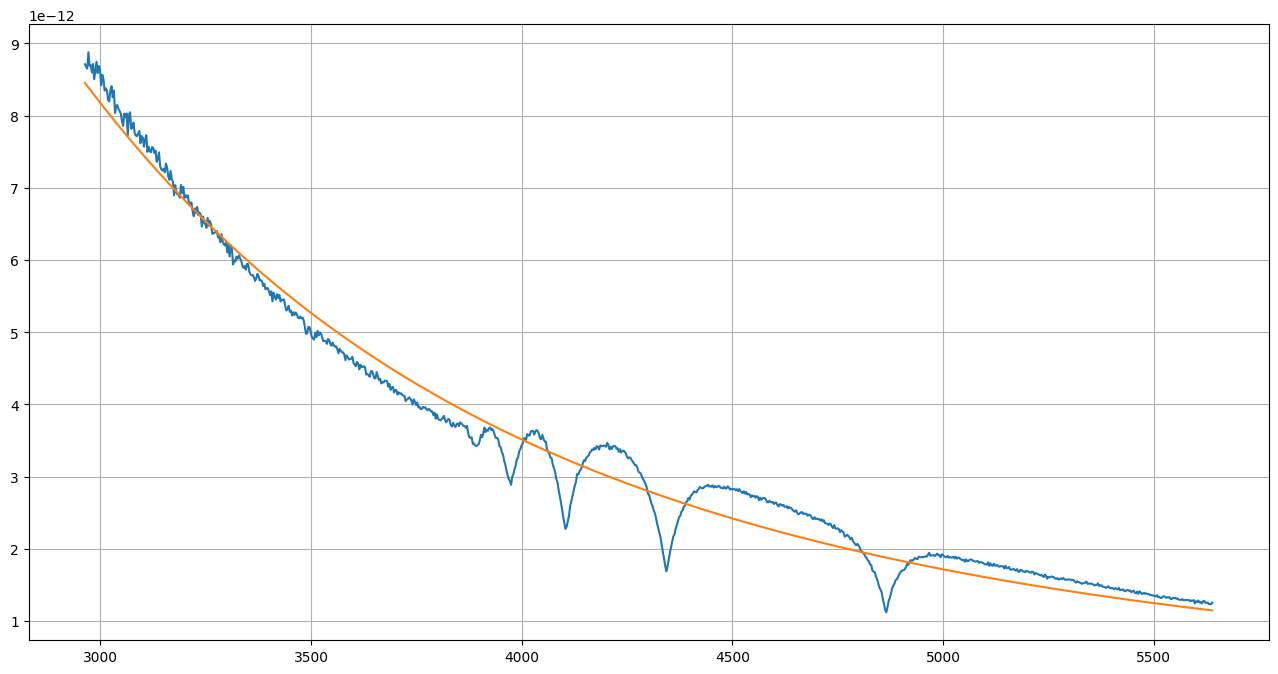

In [11]:
def extractSpectrum(filename):
    # Open the FITS file
    hdu_list = fits.open(filename)

    # Extract the data
    data = hdu_list[1].data

    # In many HST data, the first HDU is just a header, so the actual data is stored in second HDU

    # Extract the flux and wavelength
    flux = data['FLUX'].flatten()  
    wavelength = data['WAVELENGTH'].flatten()  

    # Close the FITS file
    hdu_list.close()
    
    return flux, wavelength

# Flux units for HST
flux_units = u.erg/u.s/u.cm**2/u.AA
filename = "data/SiriusB_O8P901010_sx1.fits"
flux_full, wavelength_full = extractSpectrum(filename)

# There is some noise on the shorter and longer end, strip it.
flux = flux_full[25:1000]
wavelength = wavelength_full[25:1000]

temp_guess = 5000
initial_guess = [temp_guess, 1e-17]  

# ideally should set lower bound of temp to be a low positive number, but this
# appears to shift the results in some cases.  Need to research.
bounds=((-np.inf, -np.inf), (np.inf, np.inf))

def blackbody_function (wavelength, temp, scale):
    wavelength = wavelength * u.AA
    bb = BlackBody(temperature=temp*u.K, scale=scale*flux_units/u.sr)
    return bb(wavelength).value

params_opt, params_cov = curve_fit(blackbody_function, wavelength, flux, p0=initial_guess, bounds=bounds)

fitted_temperature, fitted_scale = params_opt
fitted_temperature *= u.K
print("Fitted Temperature:", fitted_temperature)
print("Fitted Amplitude:", fitted_scale)

bb = BlackBody(temperature=fitted_temperature, scale=fitted_scale*flux_units/u.sr)
flux_fitted = bb(wavelength)

# Plot
plt.figure(figsize=(16, 8))
plt.plot(wavelength, flux)
plt.plot(wavelength, flux_fitted)
plt.grid()
plt.show()


## Size of Sirius B from Luminosity and Temperature

We can solve for the approximate radius by solving the above equation for R. (Note this is approximate as it is based on an ideal blackbody curve.)

$$ R = \sqrt{\frac{L}{4 \pi \sigma T^4}} $$



In [12]:
# Sirius B is very hot. Published value is 25000 K.
sirius_b_temp = fitted_temperature

def calculateRadius(luminosity, temp):
    return np.sqrt(luminosity/(4*np.pi*const.sigma_sb*temp**4))

sirius_b_radius = calculateRadius(sirius_b_luminosity, sirius_b_temp)
print(f"Sirius B: Radius {sirius_b_radius.to(u.km):.3f}")

# Note published value is a bit different, probably due to some deviations from the ideal model from these equations.
# The real value is actually just a bit smaller than the earth radius
sirius_b_radius_published = 0.0084 * const.R_sun
print(f"Sirius B: Radius Published {sirius_b_radius_published.to(u.km):.3f}")
print(f"Earth: Radius Published {const.R_earth.to(u.km):.3f}")

Sirius B: Radius 1782.691 km
Sirius B: Radius Published 5843.880 km
Earth: Radius Published 6378.100 km


### Appendix: Alternative way of querying data from Hipparcos

In [13]:
from astroquery.vizier import Vizier

alt_c_a = SkyCoord.from_name("Sirius A")

# Set the Vizier instance to use the Hipparcos catalog
catalog = "I/239/hip_main"
v = Vizier(columns=['HIP', 'RAhms', 'DEdms', 'Vmag', 'Plx', 'B-V', 'SpType'], row_limit=-1, catalog=catalog)
result = v.query_region(SkyCoord(alt_c_a.ra.deg, alt_c_a.dec.deg, unit=(u.deg, u.deg)), radius="0.02 deg")

# Extract data
alt_sirius_a_coor = SkyCoord(result[catalog]['RAhms'][0], result[catalog]['DEdms'][0], unit=(u.hourangle, u.deg))
alt_sirius_a_app_mag = result[catalog]['Vmag'][0] # Magnitude in Johnson V 
alt_sirius_a_parallax = result[catalog]['Plx'][0] * u.mas

print(f"Sirius A: RA = {alt_sirius_a_coor.ra:.4f}; dec = {alt_sirius_a_coor.dec:.4f}")
print(f"Sirius A: Apparent Magnitude {alt_sirius_a_app_mag:.2f}")
print(f"Sirius A: Parallax {alt_sirius_a_parallax:.2f}")

Sirius A: RA = 101.2885 deg; dec = -16.7131 deg
Sirius A: Apparent Magnitude -1.44
Sirius A: Parallax 379.21 mas
